Jacobian test with various spectra
==================================

We have speculated that there may be an error in the way that the C1 correction was performed for BL1. Jeff Nico's paper defines
$$c_1=\dfrac{\bar{\rho}\sigma_0 \frac{N_A}{A} \int_v \frac{v_0}{v} I(v) dv}{\int_v \left( 1 - e^{-\bar{\rho}\sigma_0 \frac{N_A}{A} \frac{v_0}{v}} \right) I(v) dv}$$
and we have shown that this can be re-expressed in terms of a wavelength spectrum as
$$c_1=\dfrac{C_0 \int_v \frac{I(\lambda)}{\lambda_0 \lambda}  d\lambda}{\int_v \left( 1 - e^{-C_0 \frac{\lambda}{\lambda_0}} \right) \dfrac{I(\lambda)}{\lambda^2} d\lambda}$$
This transformation has been verified in a separate Mathematica notebook.

We have evaluated the latter version several times with different spectra and are getting corrections that amount to 3.x seconds in all cases, comparing poorly with the 5.4 seconds in the Nico paper. 

However, we have a MathCAD document from Scott Dewey that makes it appear as though he plugged the wavelength spectrum into the velocity integral form, without making the proper change of variables. Moreover, Gordon has obtained 5.x seconds from Nadia's spectrum but making the same error of ignoring the Jacobian correction to the integrals. I want to test this idea with all the spectra that I have.

I start with a bunch of tools and numbers.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps, trapz

rho = 39.3E-6/1e-4  # Deposit areal density (g/m^2)
sigma = 941E-28     # 6Li absorption cross-section (m^2)
NA = 6.02214076E23  # Avogadro's number in atoms/mol
A = 6.01512         # 6Li density in g/mol 
C0 = rho*sigma*NA/A # Dimensionless constant from integrals
print(f'C0 = {C0}')
v0 = 2200           # Reference velocity (m/s)
kn = 12398.4 * 299792458 / 939565421 # = velocity * wavelength (Constant, see NSPectrum2.ipynb
print(f'kn = {kn}')
lambda0 = kn/v0     # Reference wavelength
print(f'lambda0 = {lambda0}')
tau = 886.3         # Base neutron lifetime (s)

def numIntL(l, I):  # Compute numerator integral in wavelength form
    num = C0 * simps(I/(l * lambda0), l)
    print(f'L numerator = {num}')
    return num

def denIntL(l, I):  # Compute denominator integral in wavelength form
    pre = 1 - np.exp(-C0 * l / lambda0)
    den = simps(pre * I/(l * l), l)
    print(f'L denominator = {den}')
    return den

def lInt(l, I):     # Compute C1 by wavelength method, print time correction
    C1 = numIntL(l, I)/denIntL(l, I)
    corr = (C1 - 1) * tau
    print(f'C1 by lambda method = {C1}')
    print(f'Correction by lambda method = {corr}')
    return C1
    
def numIntS(l, I):  # Compute numerator integral Scott's way
    num = C0 * simps(I*(l/lambda0), l)
    print(f'S numerator = {num}')
    return num

def denIntS(l, I):  # Compute denominator integral Scott's way
    pre = 1 - np.exp(-C0 * l / lambda0)
    den = simps(pre * I, l)
    print(f'S denominator = {den}')
    return den
    
def sInt(l, I):     # Compute C1 by wavelength method, print time correction
    C1 = numIntS(l, I)/denIntS(l, I)
    corr = (C1 - 1) * tau
    print(f"Correction by Scotts method = {corr}")
    return C1


C0 = 0.0037024464031937517
kn = 3956.0276785316046
lambda0 = 1.7981943993325475


We will start with Nadia's BL2 spectrum.

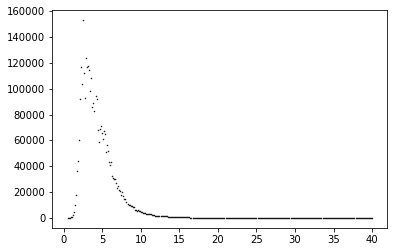

In [3]:
BL2dat = np.loadtxt('NGCData/Lmon_afterc2_Nadia_2_19_16_BL2_num.csv', delimiter=',')
BL2lambda = BL2dat[:,0]
BL2inten = BL2dat[:,1]
plt.plot(BL2lambda, BL2inten, 'k.', markersize=1)

In [27]:
BL2C1 = lInt(BL2lambda, BL2inten)

L numerator = 253.78888655076955
L denominator = 252.8538188251483
C1 by lambda method = 1.0036980565686764
Correction by lambda method = 3.2775875368178835


Now repeat with Scott's method.

In [24]:
SBL2C1 = sInt(BL2lambda, BL2inten)

S numerator = 3998.127689115392
S denominator = 3975.4867391054117
Correction by Scotts method = 5.047601793374617


Oh dear, well that is interesting!!!

Right, let's try with a different spectrum. The worst spectrum I have is the very low resolution NG6 spectrum that may be from 2013. Let's try it.

Note that this comes as a capture flux spectrum and must be converted to total flux.

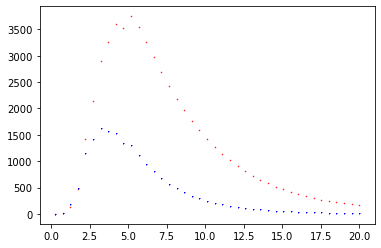

In [26]:
cf6 = np.loadtxt('NG6Data/NG6CapFlux.txt')
cfl6 = cf6[:,0]
cfi6 = cf6[:,1]
plt.plot(cfl6,cfi6,'r.', markersize=1)
tfi6 = cfi6 * lambda0 / cfl6
plt.plot(cfl6,tfi6,'b+', markersize=1)

Using the total flux spectrum we get by the wavelength method

In [28]:
cf6C0 = lInt(cfl6, tfi6)

L numerator = 4.326037894097209
L denominator = 4.3073497223723765
C1 by lambda method = 1.0043386706279656
Correction by lambda method = 3.8453637775658733


and by Scott's method

In [30]:
Stf6C0 = sInt(cfl6, tfi6)

S numerator = 101.5537874546022
S denominator = 100.79503540042035
Correction by Scotts method = 6.671776471429013


High, but it is a crappy spectrum. What if I use the capture flux spectrum.

In [31]:
Scf6C0 = sInt(cfl6, cfi6)

S numerator = 412.4756647950605
S denominator = 408.56753546928525
Correction by Scotts method = 8.477851813301914


OK, so that is really bad.

The last spectrum worth trying is the Emit spectrum, which is from NG-6 but with a super-mirror polarizer added.

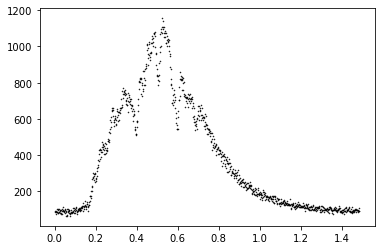

In [32]:
E6dat = np.loadtxt('NG6Data/NG6_EmitwSPM.txt', delimiter=',')
E6lambda = E6dat[:,1]
E6inten = E6dat[:,2]
plt.plot(E6lambda, E6inten, 'k.', markersize=1)

In [33]:
E6C0 = lInt(E6lambda, E6inten)

L numerator = 3.06825905531955
L denominator = 3.067091376907622
C1 by lambda method = 1.0003807119738002
Correction by lambda method = 0.3374250223791041


In [35]:
E6B = E6inten * lambda0 / E6lambda
E6BC0 = lInt(E6lambda, E6B)

L numerator = 228.60712347589708
L denominator = 228.60144488568307
C1 by lambda method = 1.0000248405700884
Correction by lambda method = 0.022016197269390456


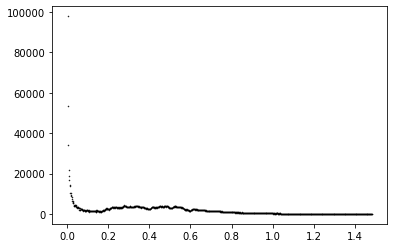

In [36]:
plt.plot(E6lambda, E6B, 'k.', markersize=1)

In [37]:
sInt(E6lambda, E6B)

S numerator = 2.040406623508086
S denominator = 2.039145737648608
Correction by Scotts method = 0.5480349523932884


1.0006183402373838

In [38]:
sInt(E6lambda, E6inten)

S numerator = 0.681455979715003
S denominator = 0.6809364596600125
Correction by Scotts method = 0.6762020423580136


1.0007629493877446

So none of the Emit spectra give sensible answers.

This is suggestive but not conclusive.